In [472]:
%run init.ipynb

# Impact-based Similarity

This notebook is intended for explaining the functionalities and providing some preliminary tests on the impact-based similarity  concepts of BPMN processes. Feel free to modify the code and/or apply it to your BPMN processes.

## Writing Single Entry Single Exit (SESE) BPMN diagrams

For the sake of simplicity we focus on Single Entry Single Exit (SESE) BPMN diagrams ***TODO: citation*** with a restricted BPMN syntax, as explained in the papeer this diagrams may be easily encoded as region trees. Let us point out that you can always convert a BPMN diagram into equivalent SESE BPMN diagram ***TODO: citation*** and there are libraries that perform such task (e.g., ***TODO: find library and cite***). We do not deal here with such encodings, instead we assume that our BPMN diagram (diagram form now on) is always in SESE form and thus can be expressed with the following context-free grammar (parser is provided by the very intuitive Lark python library ***TODO: find library and cite***).

## 

In [473]:
sese_diagram_grammar = r"""
?start: xor

?xor: parallel
    | xor "^" parallel -> xor
    | xor "^" "[" NAME "]" parallel -> xor_probability

?parallel: sequential
    | parallel "||" sequential  -> parallel

?sequential: region
    | sequential "," region -> sequential    

?region: 
     | NAME   -> task
     | "(@" xor "@)" -> loop
     | "(@" "[" NAME "]"  xor "@)" -> loop_probability
     | "(" xor ")"

%import common.CNAME -> NAME
%import common.NUMBER
%import common.WS_INLINE

%ignore WS_INLINE
"""

SESE_PARSER = Lark(sese_diagram_grammar, parser='lalr')


By means of such small language the user is able to either write directly its SESE diagram as a region tree or to convert a SESE diagram (expressed in the standard XML for BPMN diagrams ***TODO: citation***) into an equivalent region tree in the language provided above. Since it is outside the scope of this notebook, implementing such a translation is left to the user. 

Elements in the diagrams may be possibly enriched with :


 - impacts, given $h\geq 0$ as the number of non-cumulative impacts (e.g., time)  for some task $t$  assign a vector  $\mathcal{IC}_t \in \mathbb{N}^{k+h}$, tasks $t$ with unspecified impacts are assumed to have $\mathcal{IC}_t = 0^{k+h}$;

- split probability ***TODO***

- loop threshold ***TODO***


### Language Usage

In the following we will illustrate the meaning and the usage of our context free language for representing diagrams. For this and debugging purposes we make use of both the diagram representation and the region tree representation
provided by the following functions, respectively:

```python
    print_sese_diagram(expression, h, probabilities, impacts, loop_thresholds, outfile)
```

and 

```python
    print_region_tree(tree, h, probabilities, impacts, loop_thresholds, outfile)
```

Where:
- ```expression```  the current word in the context-free grammar above;
- ```h``` is the number of non-cumulative impacts, 
- ```probabilities``` is a dictionary mapping some labels asociated to XOR-split
gateway to a probability associated to one of its branch. We assume to have binary splits and  for splits associated to loops
this represents the looping probability, if the probability is missing we assume that it is equal to $0.5$;
- ```impacts``` ***TODO***
- ```loop_thresholds``` ***TODO***
- ```outfile``` ***TODO***




#### Tasks

Simple (no impacts):

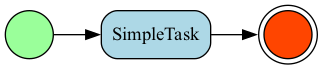

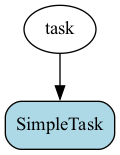

In [474]:
expression = 'SimpleTask'
display(print_sese_diagram(expression,outfile='d.png'), print_sese_tree(expression, outfile='t.png'))

With just cumulative impacts:

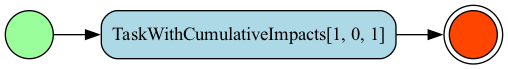

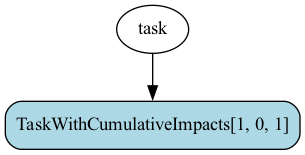

In [475]:
args = {
    'expression':'TaskWithCumulativeImpacts',
    'h':0,
    'impacts': {'TaskWithCumulativeImpacts': [1,0,1]},
}
display(print_sese_diagram(**args,outfile='d.png'), print_sese_tree(**args, outfile='t.png'))


With just non-cumulative impacts:

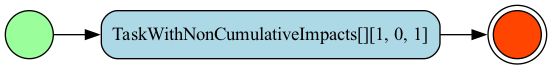

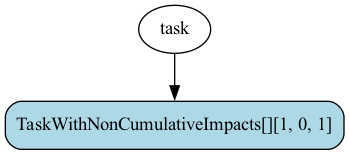

In [476]:
args = {
    'expression':'TaskWithNonCumulativeImpacts',
    'h':3,
    'impacts': {'TaskWithNonCumulativeImpacts': [1,0,1]},
}
display(print_sese_diagram(**args,outfile='d.png'), print_sese_tree(**args, outfile='t.png'))


With both comulative (one) and non-cumulative impacts (two):

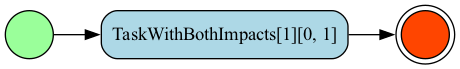

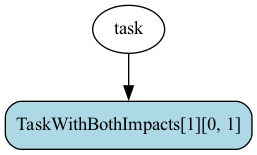

In [477]:
args = {
    'expression':'TaskWithBothImpacts',
    'h':2,
    'impacts': {'TaskWithBothImpacts': [1,0,1]},
}
display(print_sese_diagram(**args,outfile='d.png'), print_sese_tree(**args, outfile='t.png'))


#### Sequential Composition

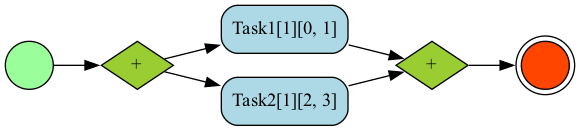

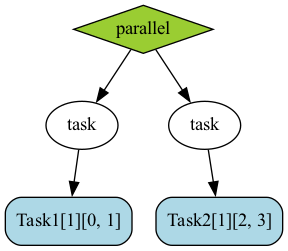

In [478]:
args = {
    'expression':'Task1 || Task2',
    'h':2,
    'impacts': {'Task1': [1,0,1], 'Task2':[1,2,3]},
}
display(print_sese_diagram(**args,outfile='d.png'), print_sese_tree(**args, outfile='t.png'))

#### Parallel Gateway

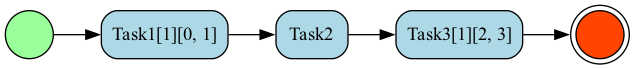

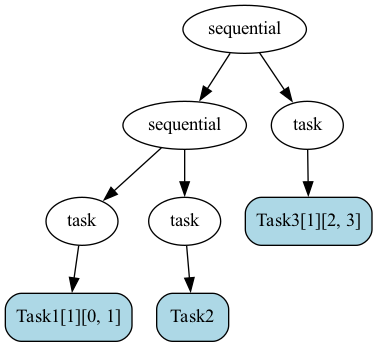

In [479]:
args = {
    'expression':'Task1, Task2,Task3',
    'h':2,
    'impacts': {'Task1': [1,0,1], 'Task3':[1,2,3]},
}
display(print_sese_diagram(**args,outfile='d.png'), print_sese_tree(**args, outfile='t.png'))

#### Exclusive Gateway

With equal probability for each branch:

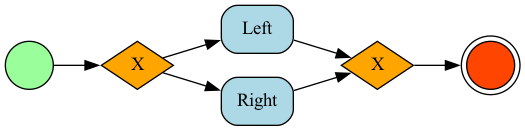

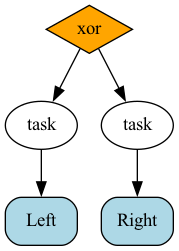

In [480]:
args = {
    'expression':'Left ^ Right'
}
display(print_sese_diagram(**args,outfile='d.png'), print_sese_tree(**args, outfile='t.png'))


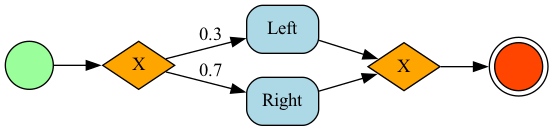

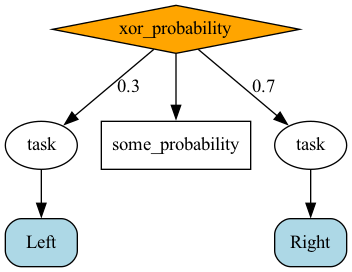

In [481]:
args = {
    'expression':'Left ^ [some_probability] Right',
    'probabilities': {'some_probability': 0.3}
}
display(print_sese_diagram(**args,outfile='d.png'), print_sese_tree(**args, outfile='t.png'))


In [482]:



SESE_PARSER.parse('Left ^[some_probability] Right').children[1].value

'some_probability'

#### Loops 

Loop with $(p,t) =(0.5,0.5)$, resulting in no looping: 

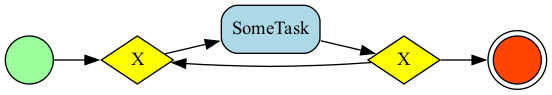

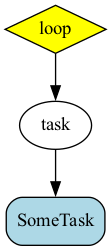

In [483]:
args = {
    'expression':'(@ SomeTask @)',
}
display(print_sese_diagram(**args,outfile='d.png'), print_sese_tree(**args, outfile='t.png'))

Loop with  assigned $(p,t)$: 

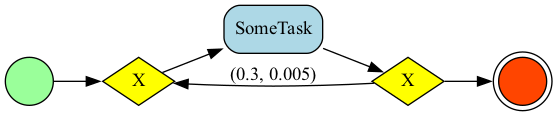

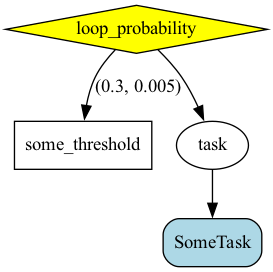

In [484]:
args = {
    'expression':'(@[some_threshold] SomeTask @)',
    'loop_thresholds': {'some_threshold': (0.3, 0.005)}
}
display(print_sese_diagram(**args,outfile='d.png'), print_sese_tree(**args, outfile='t.png'))

## Computing Average/Maximum/Minimum Impacts

In the following we provide and describe an algorithm that compute the average/minimum/maximum impacts
given a diagram expressed in the language provided in the previous section possibly together with ***TODO***

In [485]:
def compute_sese_impacts(expression, h=0, probabilities ={}, impacts={}, loop_thresholds={}):
    tree = SESE_PARSER.parse(expression)
    impact_dim = len(impacts[list(impacts.keys())[0]])
    return compute_region_tree_impacts(tree, h, probabilities, impacts, loop_thresholds, impact_dim)

In [486]:
def get_task_name(tree):
    return tree.children[0].value


def compute_region_tree_impacts(tree, h, probabilities, impacts, loop_thresholds, impact_dim):
    if (tree.data == 'task'):
        task_name = get_task_name(tree)
        if task_name in impacts:
            avg_impact = min_impact = max_impact = impacts[task_name]
        else:
            avg_impact = min_impact = max_impact = [0 for _ in range(impact_dim)]
        return avg_impact, min_impact, max_impact
    elif (tree.data == 'sequential'):
        return compute_region_tree_impacts_sequential(tree, h, probabilities, impacts, loop_thresholds, impact_dim)
    elif (tree.data == 'parallel'):
        return compute_region_tree_impacts_parallel(tree, h, probabilities, impacts, loop_thresholds, impact_dim)
    elif (tree.data in {'xor', 'xor_probability'}):
        return compute_region_tree_impacts_xor(tree, h, probabilities, impacts, loop_thresholds, impact_dim)
    elif (tree.data in {'loop', 'loop_probability'}):
        return compute_region_tree_impacts_loop(tree, h, probabilities, impacts, loop_thresholds, impact_dim)

#### Task tests
When the impact for the task is present:


In [487]:
args = {
    'expression':'SomeTask',
    'impacts': {'SomeTask':[0,1,2]}
}
compute_sese_impacts(**args)

([0, 1, 2], [0, 1, 2], [0, 1, 2])

when the impact for the task is not present:

In [488]:
args = {
    'expression':'SomeTask',
    'impacts': {'Some':[0,1,2]}
}
compute_sese_impacts(**args)

([0, 0, 0], [0, 0, 0], [0, 0, 0])

#### Sequential Composition tests


In [489]:
def sum_lists(l1, l2, tail_function = None, tail_length = 0):
   l = list(zip(l1,l2))
   return [a+b for a, b in l] if tail_length == 0 else [a+b for a, b in l[0:-tail_length]] +  [tail_function(a,b) for a, b in l[-tail_length:]]

def compute_region_tree_impacts_sequential(tree, h, probabilities, impacts, loop_thresholds, impact_dim):
    impact_children = [compute_region_tree_impacts(tree.children[i], h, probabilities, impacts, loop_thresholds, impact_dim) for i in [0,1]]
    return tuple( sum_lists(impact_children[0][i], impact_children[1][i])   for i in range(3))


In [490]:
args = {
    'expression':'SomeTask1, SomeTask2, SomeTask3',
    'impacts': {'SomeTask1':[0,1,2], 'SomeTask2':[2,3,4]}
}
compute_sese_impacts(**args)

([2, 4, 6], [2, 4, 6], [2, 4, 6])

#### Parallel Gateway tests

In [491]:
def compute_region_tree_impacts_parallel(tree, h, probabilities, impacts, loop_thresholds, impact_dim):
    impact_children = [compute_region_tree_impacts(tree.children[i], h, probabilities, impacts, loop_thresholds, impact_dim) for i in [0,1]]
    return tuple( sum_lists(impact_children[0][i], impact_children[1][i], max, h)   for i in range(3))

without non-cumulative impacts:

In [492]:
args = {
    'expression':'SomeTask1 || SomeTask2',
    'impacts': {'SomeTask1':[0,1,2], 'SomeTask2':[2,3,1]},
    'h': 0
}
compute_sese_impacts(**args)

([2, 4, 3], [2, 4, 3], [2, 4, 3])

with cumulative impacts:

In [493]:
args = {
    'expression':'SomeTask1 || SomeTask2',
    'impacts': {'SomeTask1':[0,1,2], 'SomeTask2':[2,3,1]},
    'h': 2
}
compute_sese_impacts(**args)

([2, 3, 2], [2, 3, 2], [2, 3, 2])

#### Exclusive Gateway tests


In [494]:
def get_xor_probability_label(tree):
    return tree.children[1].value

def scalar_multiplication_list(k, l):
   return  [k*a for a in l]    

def compute_region_tree_impacts_xor(tree, h, probabilities, impacts, loop_thresholds, impact_dim):
    if tree.data == 'xor':
        children_indexes, label = [0,1], None
    else:
        children_indexes, label = [0,2], get_xor_probability_label(tree) 
    probability = 0.5 if (label == None) or not(label in probabilities) else probabilities[label]
    impact_children = [compute_region_tree_impacts(tree.children[i], h, probabilities, impacts, loop_thresholds, impact_dim) for i in children_indexes]
    r_average = sum_lists(scalar_multiplication_list(probability, impact_children[0][0]),scalar_multiplication_list((1-probability), impact_children[1][0]))
    r_minimum = sum_lists( impact_children[0][1],  impact_children[1][1], min, impact_dim)
    r_maximum = sum_lists( impact_children[0][2],  impact_children[1][2], max, impact_dim)
    return r_average, r_minimum, r_maximum

with no probabilities but with labels:

In [495]:
args = {
    'expression':'SomeTask1 ^ SomeTask2',
    'impacts': {'SomeTask1':[0,1,2], 'SomeTask2':[2,3,1]},
    'h': 2
}
compute_sese_impacts(**args)

([1.0, 2.0, 1.5], [0, 1, 1], [2, 3, 2])

with probability unspecified:

In [496]:
args = {
    'expression':'SomeTask1 ^[some_probability] SomeTask2',
    'impacts': {'SomeTask1':[0,1,2], 'SomeTask2':[2,3,1]},
    'h': 2
}
compute_sese_impacts(**args)

([1.0, 2.0, 1.5], [0, 1, 1], [2, 3, 2])

with probability specified

In [497]:
args = {
    'expression':'SomeTask1 ^[some_probability] SomeTask2',
    'impacts': {'SomeTask1':[0,1,2], 'SomeTask2':[2,3,1]},
    'probabilities':{'some_probability':0.7},
    'h': 2
}
compute_sese_impacts(**args)

([0.6000000000000001, 1.6, 1.7], [0, 1, 1], [2, 3, 2])

with some impact-missing task:

In [498]:
args = {
    'expression':'SomeTask1 ^[some_probability] NoImpactTask',
    'impacts': {'SomeTask1':[0,1,2], 'SomeTask2':[2,3,1]},
    'probabilities':{'some_probability':0.7},
    'h': 2
}
compute_sese_impacts(**args)

([0.0, 0.7, 1.4], [0, 0, 0], [0, 1, 2])

#### Loop Gateway tests

In [499]:
def get_loop_threshold_label(tree):
    return tree.children[0].value

def compute_region_tree_impacts_loop(tree, h, probabilities, impacts, loop_thresholds, impact_dim):
    if tree.data == 'loop':
        children_index, label = 0, None
    else:
        children_index, label = 1, get_loop_threshold_label(tree) 
    probability, threshold = (0.5, 0.5) if (label == None) or not(label in loop_thresholds) else loop_thresholds[label]
    r_average,r_minimum,r_maximum = compute_region_tree_impacts(tree.children[children_index], h, probabilities, impacts, loop_thresholds, impact_dim)
    r_average_step, probability_step = r_average, probability
    iterations = 0
    while probability > threshold:
        r_average = sum_lists(r_average, scalar_multiplication_list(probability, r_average_step))
        probability = probability*probability_step
        iterations += 1
    return r_average, r_minimum, scalar_multiplication_list(iterations + 1, r_maximum)    

***TODO***

In [500]:
args = {
    'expression':'(@ SomeTask1 @)',
    'impacts': {'SomeTask1':[0,1,2], 'SomeTask2':[2,3,1]},
    'probabilities':{'some_probability':0.7},
    'h': 2
}
compute_sese_impacts(**args)

([0, 1, 2], [0, 1, 2], [0, 1, 2])

***TODO***

In [501]:
args = {
    'expression':'(@[some_threshold] SomeTask1 @)',
    'impacts': {'SomeTask1':[0,1,2], 'SomeTask2':[2,3,1]},
    'probabilities':{'some_probability':0.7},
    'loop_thresholds': {'some_threshold': (0.25, 0.000000000001)},
    'h': 2
}
compute_sese_impacts(**args)

([0.0, 1.3333333333321207, 2.6666666666642413], [0, 1, 2], [0, 20, 40])

## A running example

Let us consider now a running example.


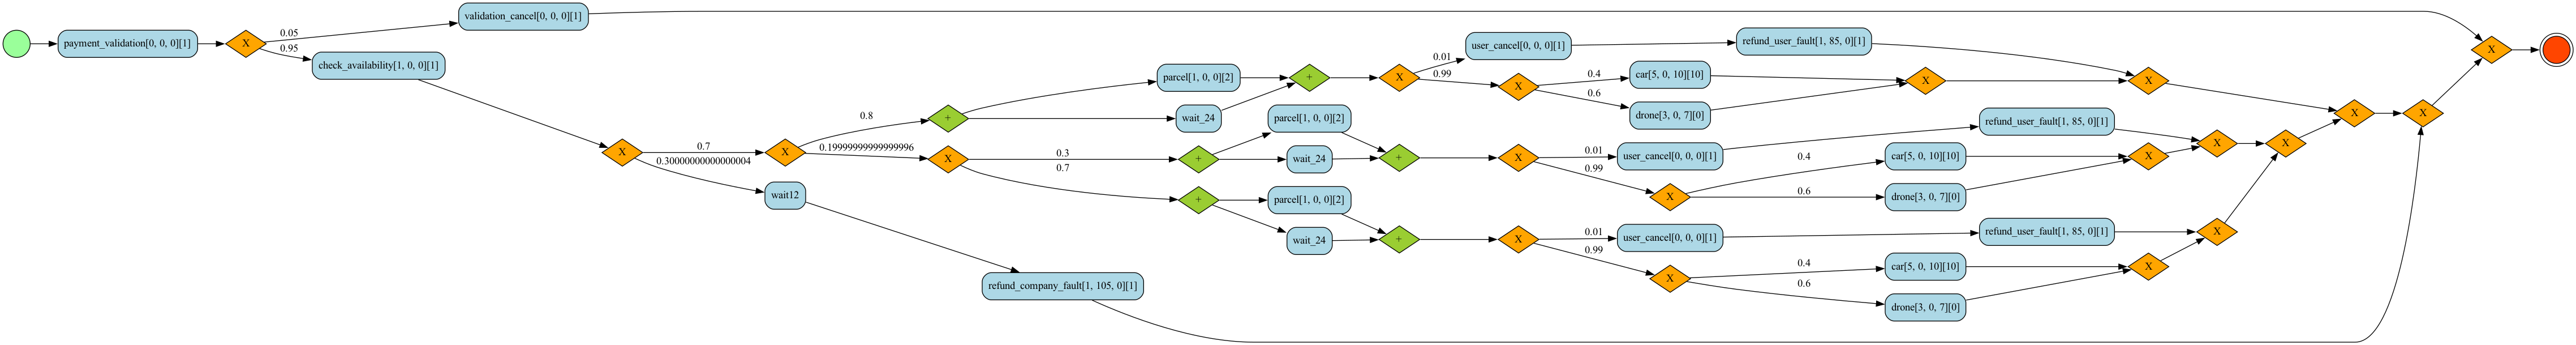

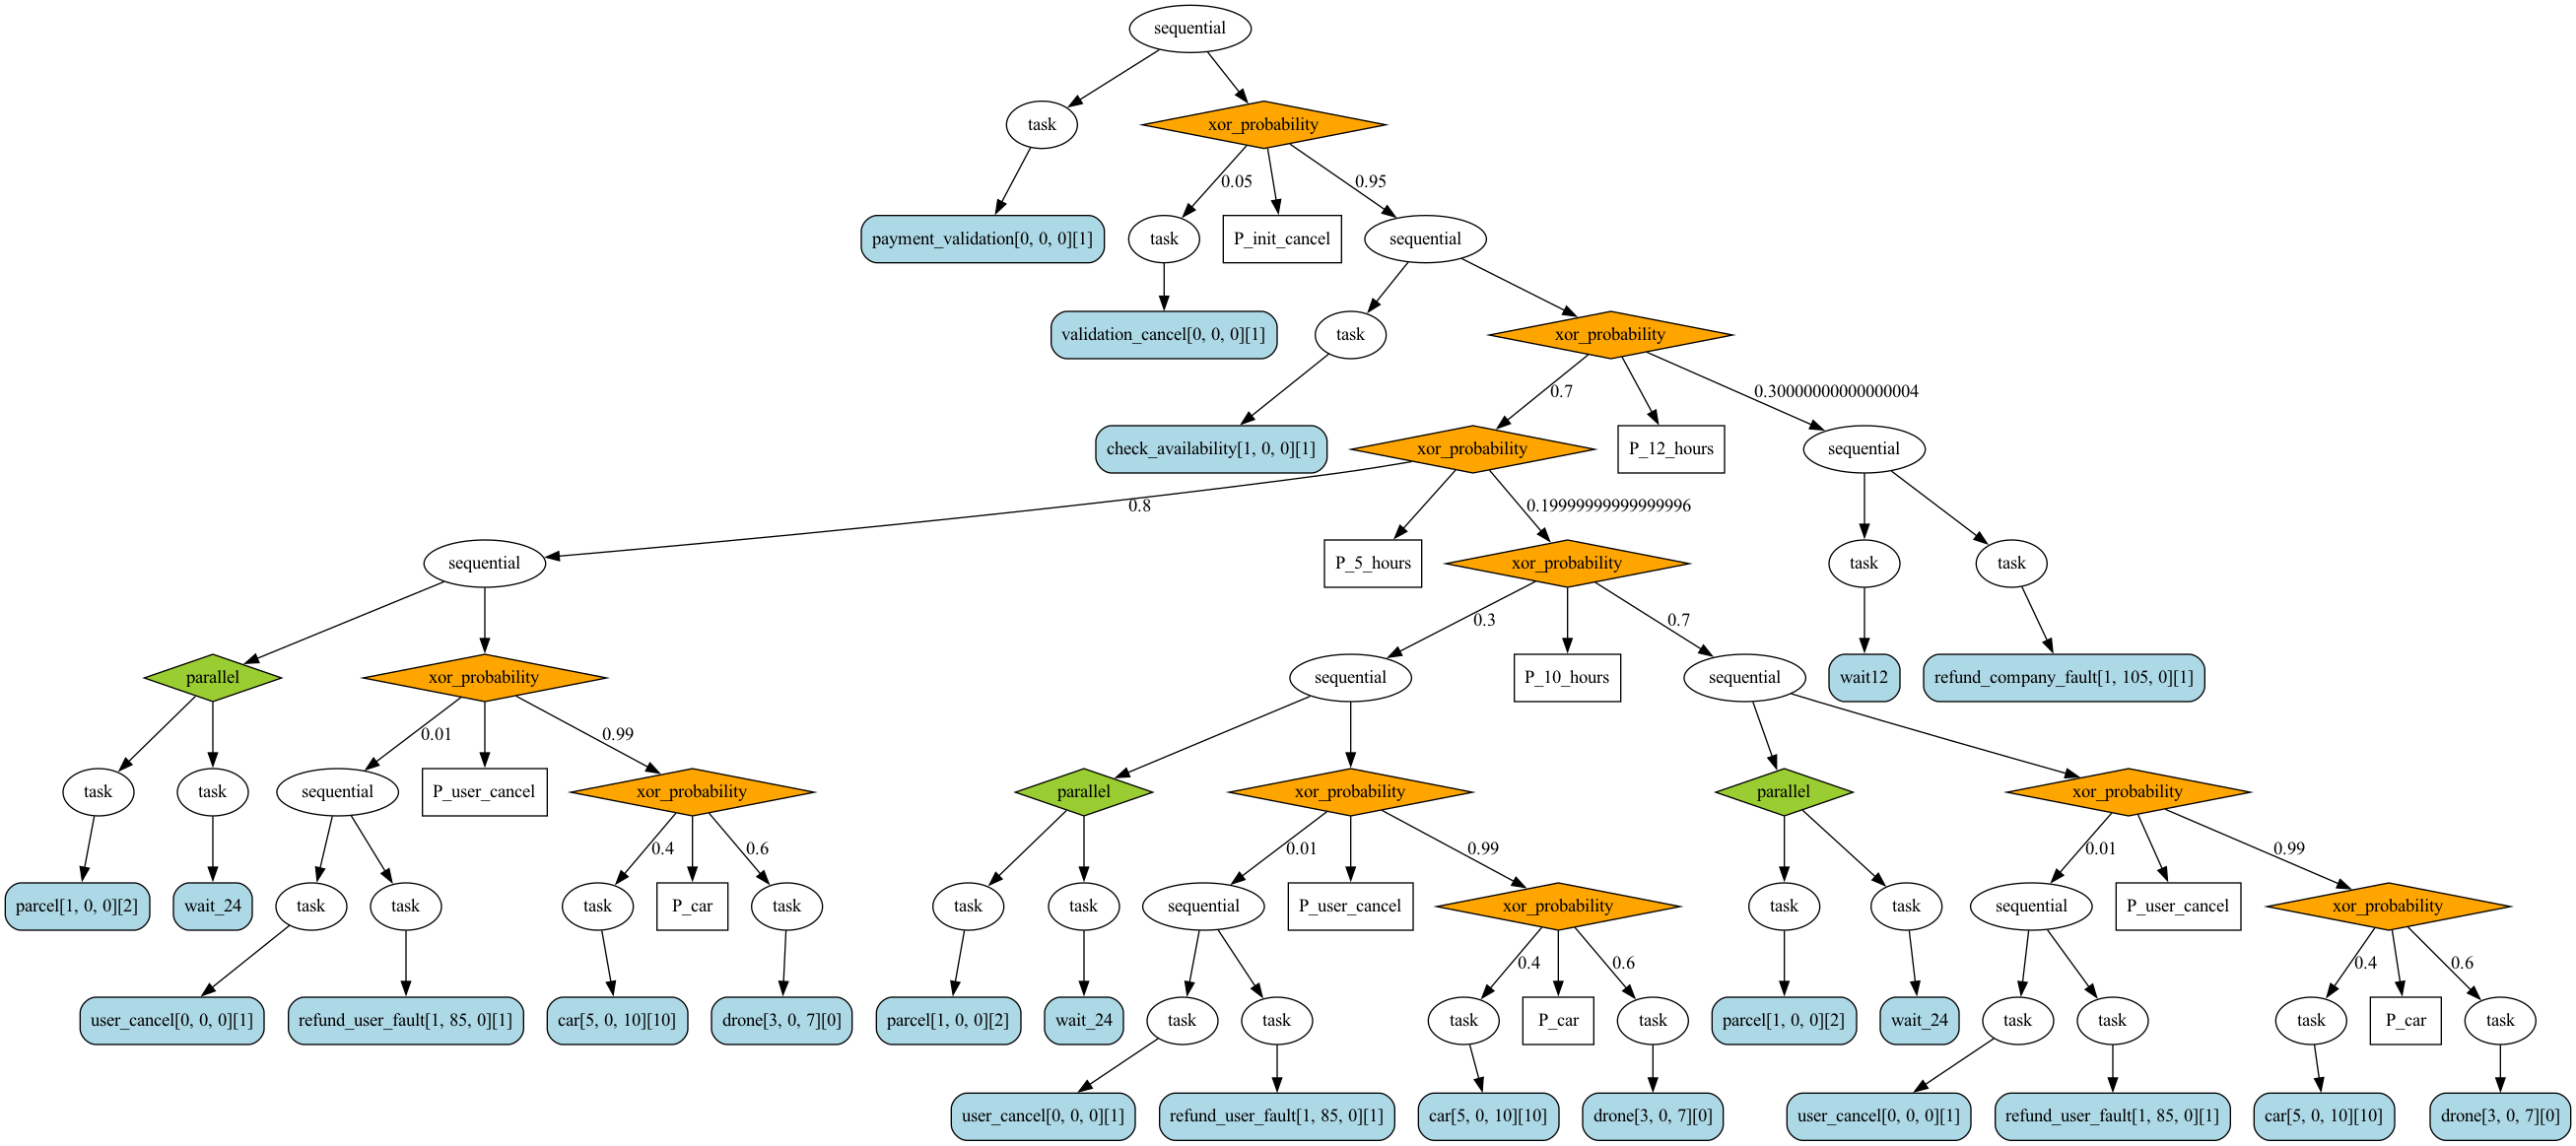

([4.408379999999999, 30.490250000000003, 5.398469999999999, 6.261699999999999],
 [0, 0, 0, 2],
 [7, 105, 10, 14])

In [507]:
b1r2 = "( parcel || wait_24 ) , ( ( user_cancel, refund_user_fault ) ^[P_user_cancel] ( car ^[P_car] drone) )  "
b1r1 = f'check_availability, (( {b1r2} ^[P_5_hours] ({b1r2} ^[P_10_hours] {b1r2}) ) ^[P_12_hours] (wait12, refund_company_fault))'
b1  = f'payment_validation, ( validation_cancel ^[P_init_cancel] {b1r1} )'
b1i = {"car":[5,0,10,10],"drone":[3,0,7,0],"payment_validation":[0,0,0,1],"validation_cancel":[0,0,0,1],"check_availability":[1,0,0,1],"refund_company_fault":[1,105,0,1,],"refund_user_fault":[1,85,0,1,],"parcel":[1,0,0,2,],"user_cancel":[0,0,0,1,]}
b1p = {"P_init_cancel": 0.05, "P_12_hours": 0.7, "P_5_hours": 0.8, "P_10_hours": 0.3, "P_car": 0.4, "P_user_cancel": 0.01}

args = {
    'expression': b1,
    'impacts': b1i,
    'probabilities':b1p,
    'loop_thresholds': {},
    'h': 1
}


display(print_sese_diagram(**args,outfile='d.png'), print_sese_tree(**args, outfile='t.png'))
compute_sese_impacts(**args)

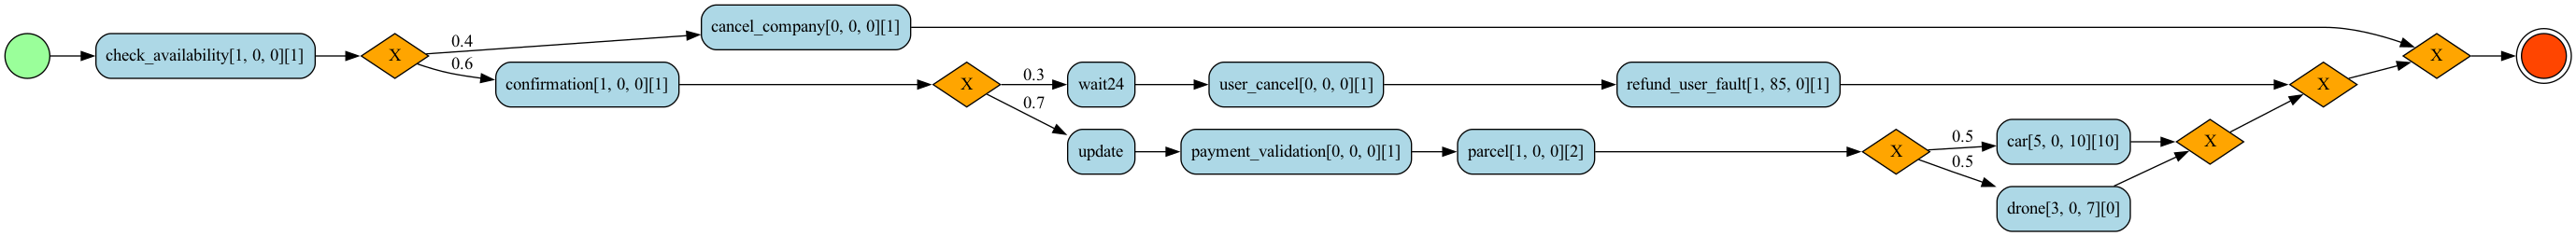

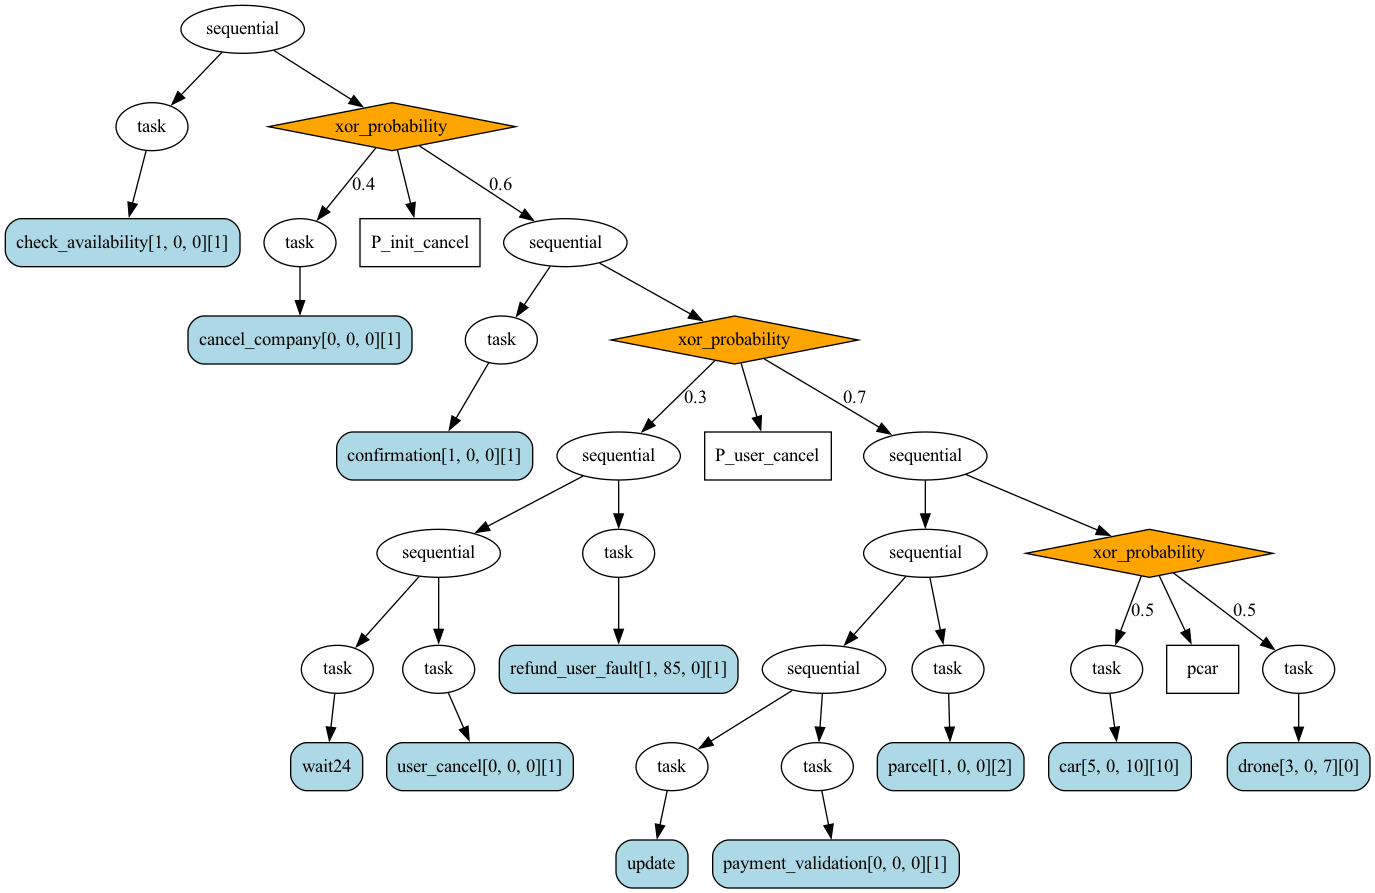

([3.88, 15.299999999999999, 3.5699999999999994, 5.72],
 [1, 0, 0, 2],
 [8, 85, 10, 15])

In [509]:
b2 = "check_availability,( cancel_company ^[P_init_cancel] ( confirmation,( (wait24, user_cancel, refund_user_fault )^[P_user_cancel] (update, payment_validation, parcel, ( car ^[pcar] drone )  )  )  )  )"
b2i = {"car":[5,0,10,10],"drone":[3,0,7,0],"payment_validation":[0,0,0,1],"confirmation":[1,0,0,1],"check_availability":[1,0,0,1],"refund_user_fault":[1,85,0,1,],"parcel":[1,0,0,2,],"user_cancel":[0,0,0,1,],"cancel_company":[0,0,0,1,]}
b2p = {"P_init_cancel": 0.4, "P_car": 0.4, "P_user_cancel": 0.3}

args = {
    'expression': b2,
    'impacts': b2i,
    'probabilities':b2p,
    'loop_thresholds': {},
    'h': 1
}

display(print_sese_diagram(**args,outfile='d.png'), print_sese_tree(**args, outfile='t.png'))
compute_sese_impacts(**args)
